In [54]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from nwb_datajoint.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from nwb_datajoint.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from nwb_datajoint.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

In [55]:
nwb_file_name = 'senor20201030_.nwb'

In [56]:
# theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])


position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()

In [57]:
electrode_id = [17,40,132,300]
time_from_start = 100 #in seconds
time_interval_s = 1000
sampling_rate_lfp = 1000
epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)
x_elect_lfp, y_elect_lfp = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)





In [58]:
from nwb_datajoint.common.signal_processing import hilbert_decomp
from scipy import signal as sig



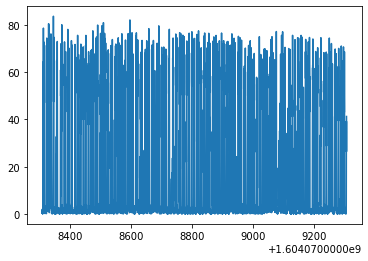

In [59]:
plt.plot(x_pos,y_pos)

frequency resolution: 5.0


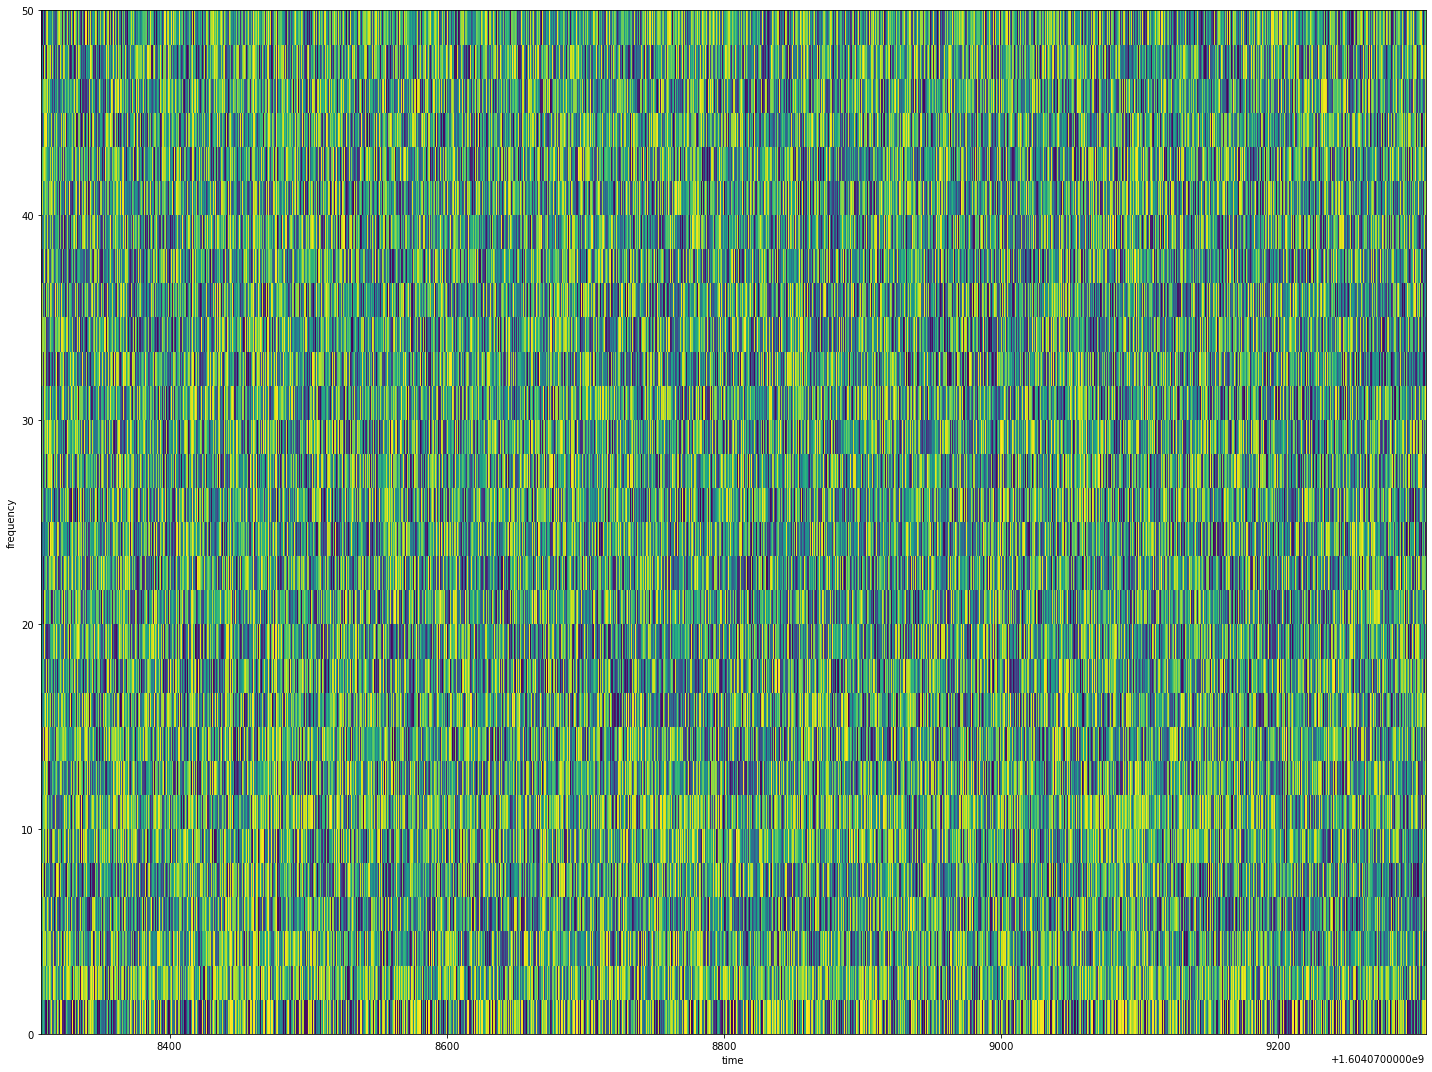

In [107]:
time_halfbandwidth_product = 1.5
sampling_frequency = 1000
n_trials = 100
time_res=.6


electrode_ix1= 1
electrode_ix2= 2


time_data = x_elect_lfp[electrode_ix1]
signal = np.zeros((len(time_data), 2))
signal[:,0] = y_elect_lfp[electrode_ix1]
signal[:,1]=y_elect_lfp[electrode_ix2]



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_res,
               time_window_step=None,
               start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
time_grid, freq_grid = np.meshgrid(
    np.append(c.time, c.time[-1]),
    np.append(c.frequencies, m.nyquist_frequency))

plt.figure(figsize=(20,15))
mesh = plt.pcolormesh(time_grid,freq_grid , c.coherence_magnitude()[..., 0, 1].squeeze().T,
                             vmin=0.0, vmax=1.0, cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
# axes[2].set_ylim(0,100)
# axes[2].set_xlim(time_data[0], time_data[-1])
plt.ylim(0,50)

# axes[3].plot(x_pos,y_pos)
# axes[3].set_xlim(time[0], time[-1])



plt.tight_layout()
# cb = fig.colorbar(mesh, ax=axes.ravel().tolist(), orientation='horizontal',
#                   shrink=.5, aspect=15, pad=0.1, label='Coherence')
# cb.outline.set_linewidth(0)
print('frequency resolution: {}'.format(m.frequency_resolution))

In [65]:
start1=1604078507.56
end1=1604078510.22
start2 = 1604078510.62
end2=1604078513.28
start3 = 1604078513.55
end3=1604078517.67
trials = [[start1, end1],[start2,end2],[start3,end3]]

In [66]:
freq_seg = c.frequencies[(c.frequencies >= 7.5) & (c.frequencies <=9)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies >= 7.5) & (c.frequencies <=9)]



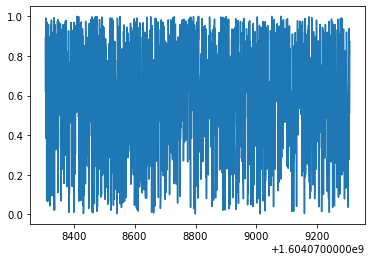

In [67]:
plt.plot(c.time,coh_seg[0])

In [68]:
trial_start=trials[0][0]
trial_end = trials[0][1]

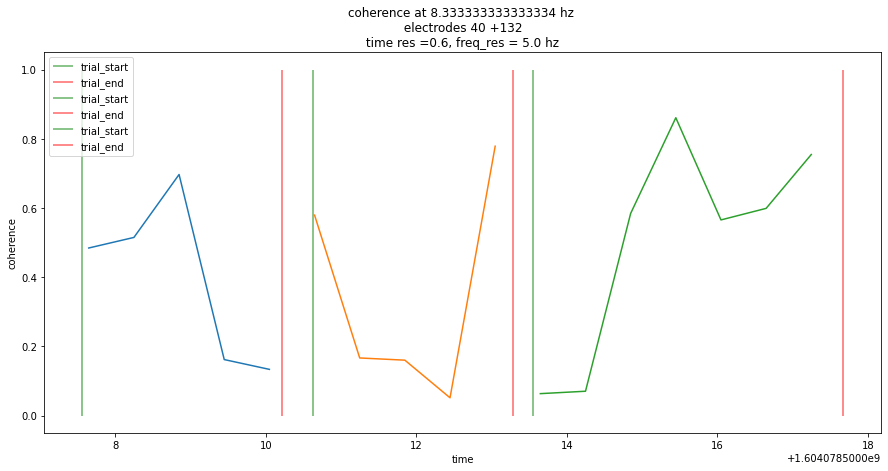

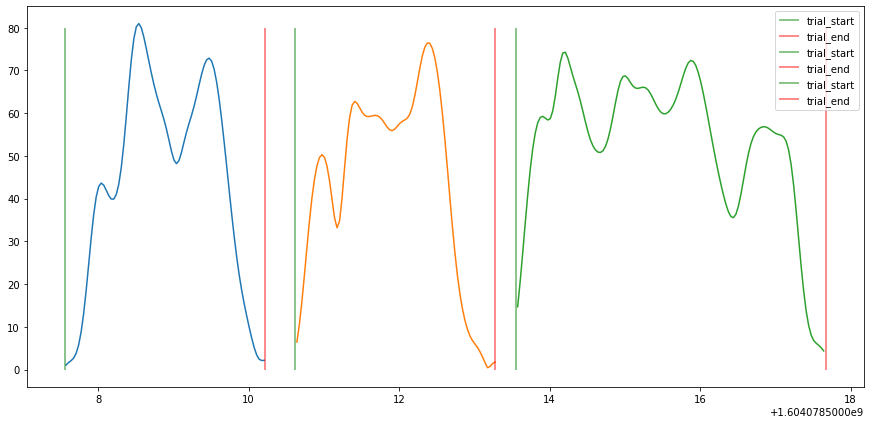

In [108]:
plt.figure(figsize=(15,7))
for times in range(len(trials)):
    trial_start=trials[times][0]
    trial_end = trials[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    plt.plot(masked_time,masked_data)
    plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
    plt.title(f'coherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz ')

plt.ylabel('coherence')
plt.xlabel('time')
plt.legend()

plt.figure(figsize=(15,7))
for times in range(len(trials)):
    trial_start=trials[times][0]
    trial_end = trials[times][1]
    ind_start = x_pos>=trial_start 
    ind_end = x_pos<=trial_end
    masked_time = x_pos[ind_start&ind_end]
    masked_data = y_pos[ind_start&ind_end]
    plt.plot(masked_time,masked_data)
    plt.vlines(trial_start,0,80,color='g',label='trial_start',alpha=.6)
    plt.vlines(trial_end,0,80,color='red',label='trial_end',alpha=.6)
    plt.legend()

In [ ]:
#start with putting them on the same acis. get the difference and schooch them 
#for all data- subtract off first trial time 
#all start at 0, subtract off everything before it.. x axis... t since trial start 
#subtract off the start trial time 


# could use position as an axis 
#shink and stretch time 

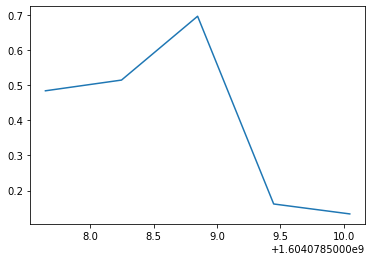

In [27]:
plt.plot(masked_time,masked_data)

In [48]:
Multitaper?

Init signature:
Multitaper(
    time_series,
    sampling_frequency=1000,
    time_halfbandwidth_product=3,
    detrend_type='constant',
    time_window_duration=None,
    time_window_step=None,
    n_tapers=None,
    tapers=None,
    start_time=0,
    n_fft_samples=None,
    n_time_samples_per_window=None,
    n_time_samples_per_step=None,
    is_low_bias=True,
)
Docstring:     
Transform time-domain signal(s) to the frequency domain by using
multiple tapering windows.

Attributes
----------
time_series : array, shape (n_time_samples, n_trials, n_signals) or
                           (n_time_samples, n_signals)
sampling_frequency : float, optional
    Number of samples per time unit the signal(s) are recorded at.
time_halfbandwidth_product : float, optional
    Specifies the time-frequency tradeoff of the tapers and also the number
    of tapers if `n_tapers` is not set.
detrend_type : string or None, optional
    Subtracting a constant or a linear trend from each time window. If Non

In [37]:
def get_pos(position_info,epoch,time_from_start, time_interval_s):
    position_start_timestamp = (position_info.index>epoch[0][0] +time_from_start)
    position_end_timestamps = (position_info.index<epoch[0][0]+time_from_start + time_interval_s)
    position_time = position_info.index[position_start_timestamp & position_end_timestamps]
    position_x = position_info.head_position_x[position_start_timestamp & position_end_timestamps]
    position_y = position_info.head_position_y[position_start_timestamp & position_end_timestamps]
    return(position_time,position_x,position_y)


In [70]:
position_time, position_x,position_y = get_pos(position_info, epoch,time_from_start,time_interval_s)

In [ ]:
#now i want to work with 1 trial, and see if i can identify the time that hes at the choice point. I would like to align each 

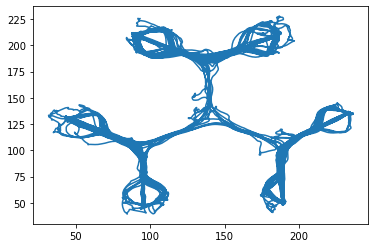

In [40]:
# plt.plot(position_info.head_position_x, position_info.head_position_y)
plt.plot(position_x,position_y)

In [41]:
trial1_start = trials[0][0]
trial1_end=trials[0][1]

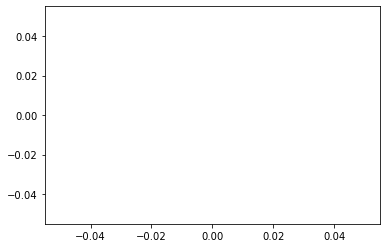

In [43]:
ind_start = position_x>=trial1_start 
ind_end = position_x <=trial1_end
masked_time =  position_x[ind_start&ind_end]
masked_data =  position_y[ind_start&ind_end]
plt.plot(masked_time,masked_data)

In [49]:
#abhilashas suggestion- see if pfc and hpc are ipsi/contralaterally connected to choose my electrodes
# use reference instead of hpc electrode! 
#also asked about phase or frequency coherence. UGH i wish i knew. 


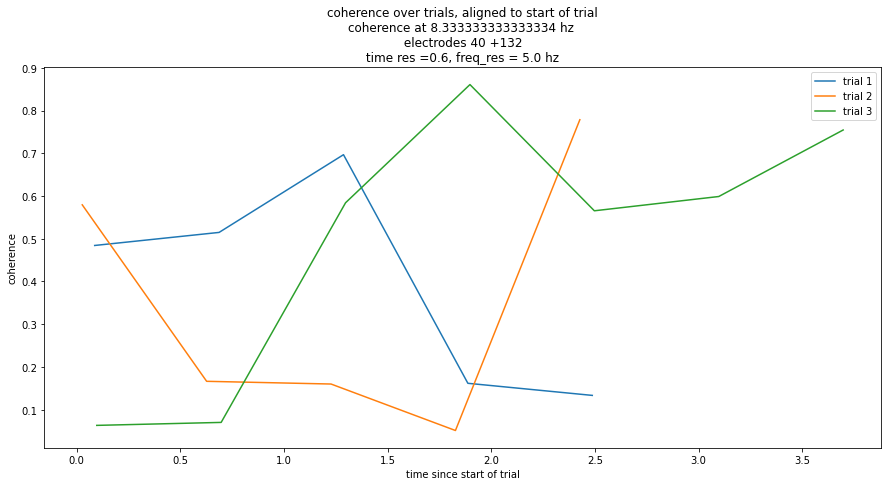

In [112]:
plt.figure(figsize=(15,7))
for times in range(len(trials)):
    trial_start=trials[times][0]
    trial_end = trials[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed=[]
#first, mask the data. 
#Then for every time in the masked times data, subtract the first time of that trial so that they all start at zero. 
    for ix in range(len(masked_time)):
        masked_times_zeroed.append(masked_time[ix]- trials[times][0])
    
    plt.plot(masked_times_zeroed,masked_data, label = f'trial {times+1}')
    # plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    # plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
# plt.title(')
plt.title(f'coherence over trials, aligned to start of trial\ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz ')


plt.ylabel('coherence')
plt.xlabel('time since start of trial')
plt.legend()

In [123]:
#to center at the end, find the legnths of each of them and all to list 

trial_len_lst=[]
for ix in range(len(trials)):
    trial=trials[ix]
    trial_len=trial[1]-trial[0]
    trial_len_lst.append(trial_len)
longest_time = max(trial_len_lst)


In [124]:
#them, find the different between each length and the longest one. You will add this difference to the zeroed times later on
#basically shifting each one by the difference in lengths 
trial_len_diff=[]
for ix in range(len(trial_len_lst)):
    trial_len_diff.append( longest_time-trial_len_lst[ix])
trial_len_diff

[1.4600000381469727, 1.4600000381469727, 0.0]

([<matplotlib.axis.XTick at 0x7f5abd351a60>,
 [Text(0.0, 0, '-4.0'),
  Text(0.5, 0, '-3.55'),
  Text(1.0, 0, '-3.0999999999999996'),
  Text(1.5, 0, '-2.6499999999999995'),
  Text(2.0, 0, '-2.1999999999999993'),
  Text(2.5, 0, '-1.7499999999999991'),
  Text(3.0, 0, '-1.299999999999999'),
  Text(3.5, 0, '-0.8499999999999988'),
  Text(4.0, 0, '-0.3999999999999986')])

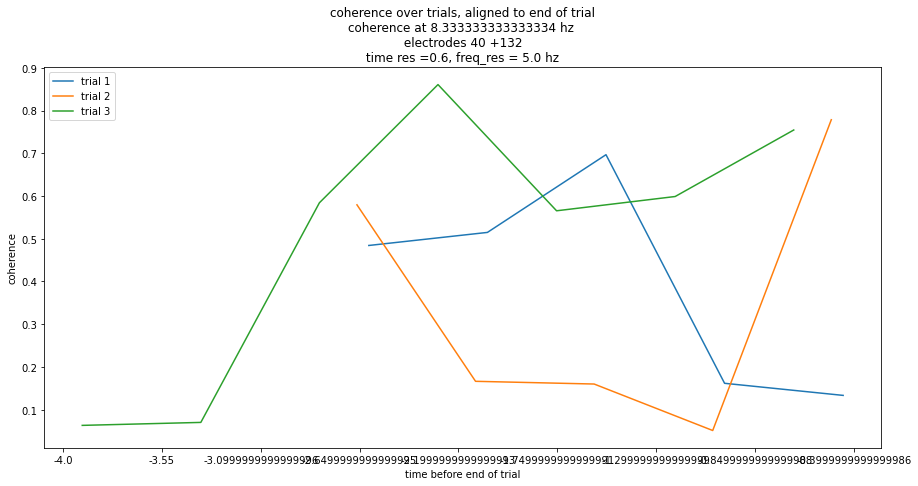

In [138]:
plt.figure(figsize=(15,7))
for times in range(len(trials)):
    trial_start=trials[times][0]
    trial_end = trials[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed_end=[]
    masked_times_zeroed_end_shift=[]
    # masked_data_zeroes = []
    for ix in range(len(masked_time)):
        masked_times_zeroed_end.append(masked_time[ix]-trials[times][0])
    for indiv_times in range(len(masked_times_zeroed_end)):
        masked_times_zeroed_end_shift.append(masked_times_zeroed_end[indiv_times] +trial_len_diff[times])
    
    plt.plot(masked_times_zeroed_end_shift,masked_data, label = f'trial {times+1}')
    # plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    # plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
# plt.title('')
plt.title(f'coherence over trials, aligned to end of trial\ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz ')


plt.ylabel('coherence')
plt.xlabel('time before end of trial')
plt.legend()
# labels = np.arange(int(-1*longest_time), 0, step=0.45)
# plt.xticks([0,.5,1,1.5,2,2.5,3,3.5,4],labels)

In [ ]:
longest_time
plt.xticks

In [132]:
labels

array([-4.12000012, -3.62000012, -3.12000012, -2.62000012, -2.12000012,
       -1.62000012, -1.12000012, -0.62000012, -0.12000012])

In [94]:
masked_times_zeroed_end

[0.09658002853393555,
 0.6965799331665039,
 1.2965798377990723,
 1.8965799808502197,
 2.496579885482788,
 3.0965800285339355,
 3.696579933166504]

In [89]:
range(len(masked_time))

range(0, 7)

In [ ]:
#difference of the two centers, add to the smallest one 

#not sure if this is actually what i did- revisit!!!!

In [119]:
#doing the same thing, except now looking at the difference between the mean of each one. shifting each one by the difference in means. 

trial_len_lst=[]
for ix in range(len(trials)):
    trial=trials[ix]
    trial_len=trial[1]-trial[0]
    trial_len_lst.append(trial_len/2)
longest_time = max(trial_len_lst)

In [120]:
longest_time

2.0600000619888306

In [121]:
trial_len_diff=[]
for ix in range(len(trial_len_lst)):
    trial_len_diff.append( longest_time-trial_len_lst[ix])
trial_len_diff

[0.7300000190734863, 0.7300000190734863, 0.0]

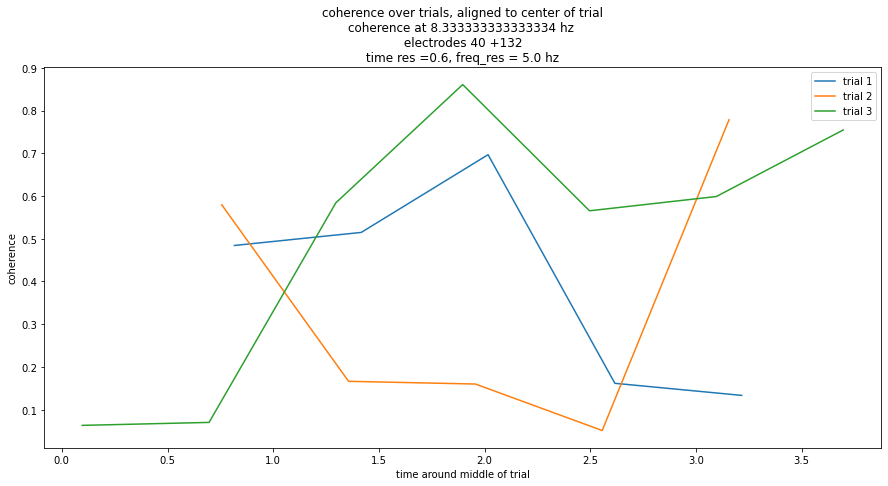

In [122]:
plt.figure(figsize=(15,7))
for times in range(len(trials)):
    trial_start=trials[times][0]
    trial_end = trials[times][1]
    ind_start = c.time>=trial_start 
    ind_end = c.time<=trial_end
    masked_time = c.time[ind_start&ind_end]
    masked_data = coh_seg[0][ind_start&ind_end]
    masked_times_zeroed_end=[]
    masked_times_zeroed_end_shift=[]
    # masked_data_zeroes = []
    for ix in range(len(masked_time)):
        masked_times_zeroed_end.append(masked_time[ix]-trials[times][0])
    for indiv_times in range(len(masked_times_zeroed_end)):
        masked_times_zeroed_end_shift.append(masked_times_zeroed_end[indiv_times] +trial_len_diff[times])
    
    plt.plot(masked_times_zeroed_end_shift,masked_data, label = f'trial {times+1}')
    # plt.vlines(trial_start,0,1,color='g',label='trial_start',alpha=.6)
    # plt.vlines(trial_end,0,1,color='red',label='trial_end',alpha=.6)
# plt.title('c')
plt.title(f'coherence over trials, aligned to center of trial\ncoherence at {freq_seg[0]} hz \n electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} \n time res ={time_res}, freq_res = {m.frequency_resolution} hz ')


plt.ylabel('coherence')
plt.xlabel('time around middle of trial')
plt.legend()

In [ ]:
#next todo is to change the xticks. 
#which actually means changing the data, maybe zero padding like cris was talking about 
#also normalizing will be the next thing. 